In [18]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf,read_raw_fif
from mne.datasets import eegbci
from mne.decoding import CSP

In [24]:
def get_data():
    #path = "dataset\\bci_dataset\\train"
    #2b path 
    path = "dataset\\2b_moabb\\train"
    test_path = "dataset\\2b_moabb\\train\\0-raw.fif"
    files = os.listdir(path)
    data_path = []
    for f in files:
        file = os.path.join(path,f)
        data_path.append(file)
        
    
    tmin, tmax = -0.2, 0.4
    event_id = dict(left=1, right = 2)

    #raw = concatenate_raws([read_raw_gdf(f, preload=True) for f in data_path])
    raw = concatenate_raws([read_raw_fif(test_path, preload=True)])
    raw_data = raw.copy()
    print(raw_data.info)
    # strip channel names of "." characters
    raw_data.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    #skip_by_annotation='edge'
    raw_data.filter(l_freq=0.5, h_freq=None)
    raw_data.notch_filter(50)

    events, _ = events_from_annotations(raw_data)
    print(events)
    
    
    picks = pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    print(picks)
    #delete eog band
    #picks = np.delete(picks,[3,4,5])
    
    # Read epochs (train will be done only between 1 and 2s)
    #reject_criteria = dict( eeg=100e-6)       # 100 µV
    # Testing will be done with a running classifier
    epochs = Epochs(raw_data, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None,preload=True)
    #epochs.crop(tmin=1., tmax=None)
    labels = epochs.events[:, 2] - 1
    return epochs.get_data()[:, :, :256], labels,epochs,raw_data


epochs_data, labels,epochs1,raw= get_data()

Opening raw data file dataset\2b_moabb\train\0-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
<Info | 10 non-empty values
 bads: []
 ch_names: C3, Cz, C4, EOG1, EOG2, EOG3, stim
 chs: 3 EEG, 3 EOG, 1 Stimulus
 custom_ref_applied: False
 dig: 6 items (3 Cardinal, 3 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 7
 projs: []
 sfreq: 250.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 1651 samples (6.604 sec)

Setting up band-stop filter from 49 - 51 

In [21]:
# 280 events
# 22 channel
# 256 Time

print(epochs_data.shape)
print(labels.shape)
print(epochs_data.shape[1])
print(labels)
print(raw.info['ch_names'])


(120, 3, 151)
(120,)
3
[0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1
 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1
 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1
 0 1 0 1 0 1 0 1 1]
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


<Epochs |  120 events (all good), -0.2 - 0.4 sec, baseline off, ~437 kB, data loaded,
 'left': 60
 'right': 60>


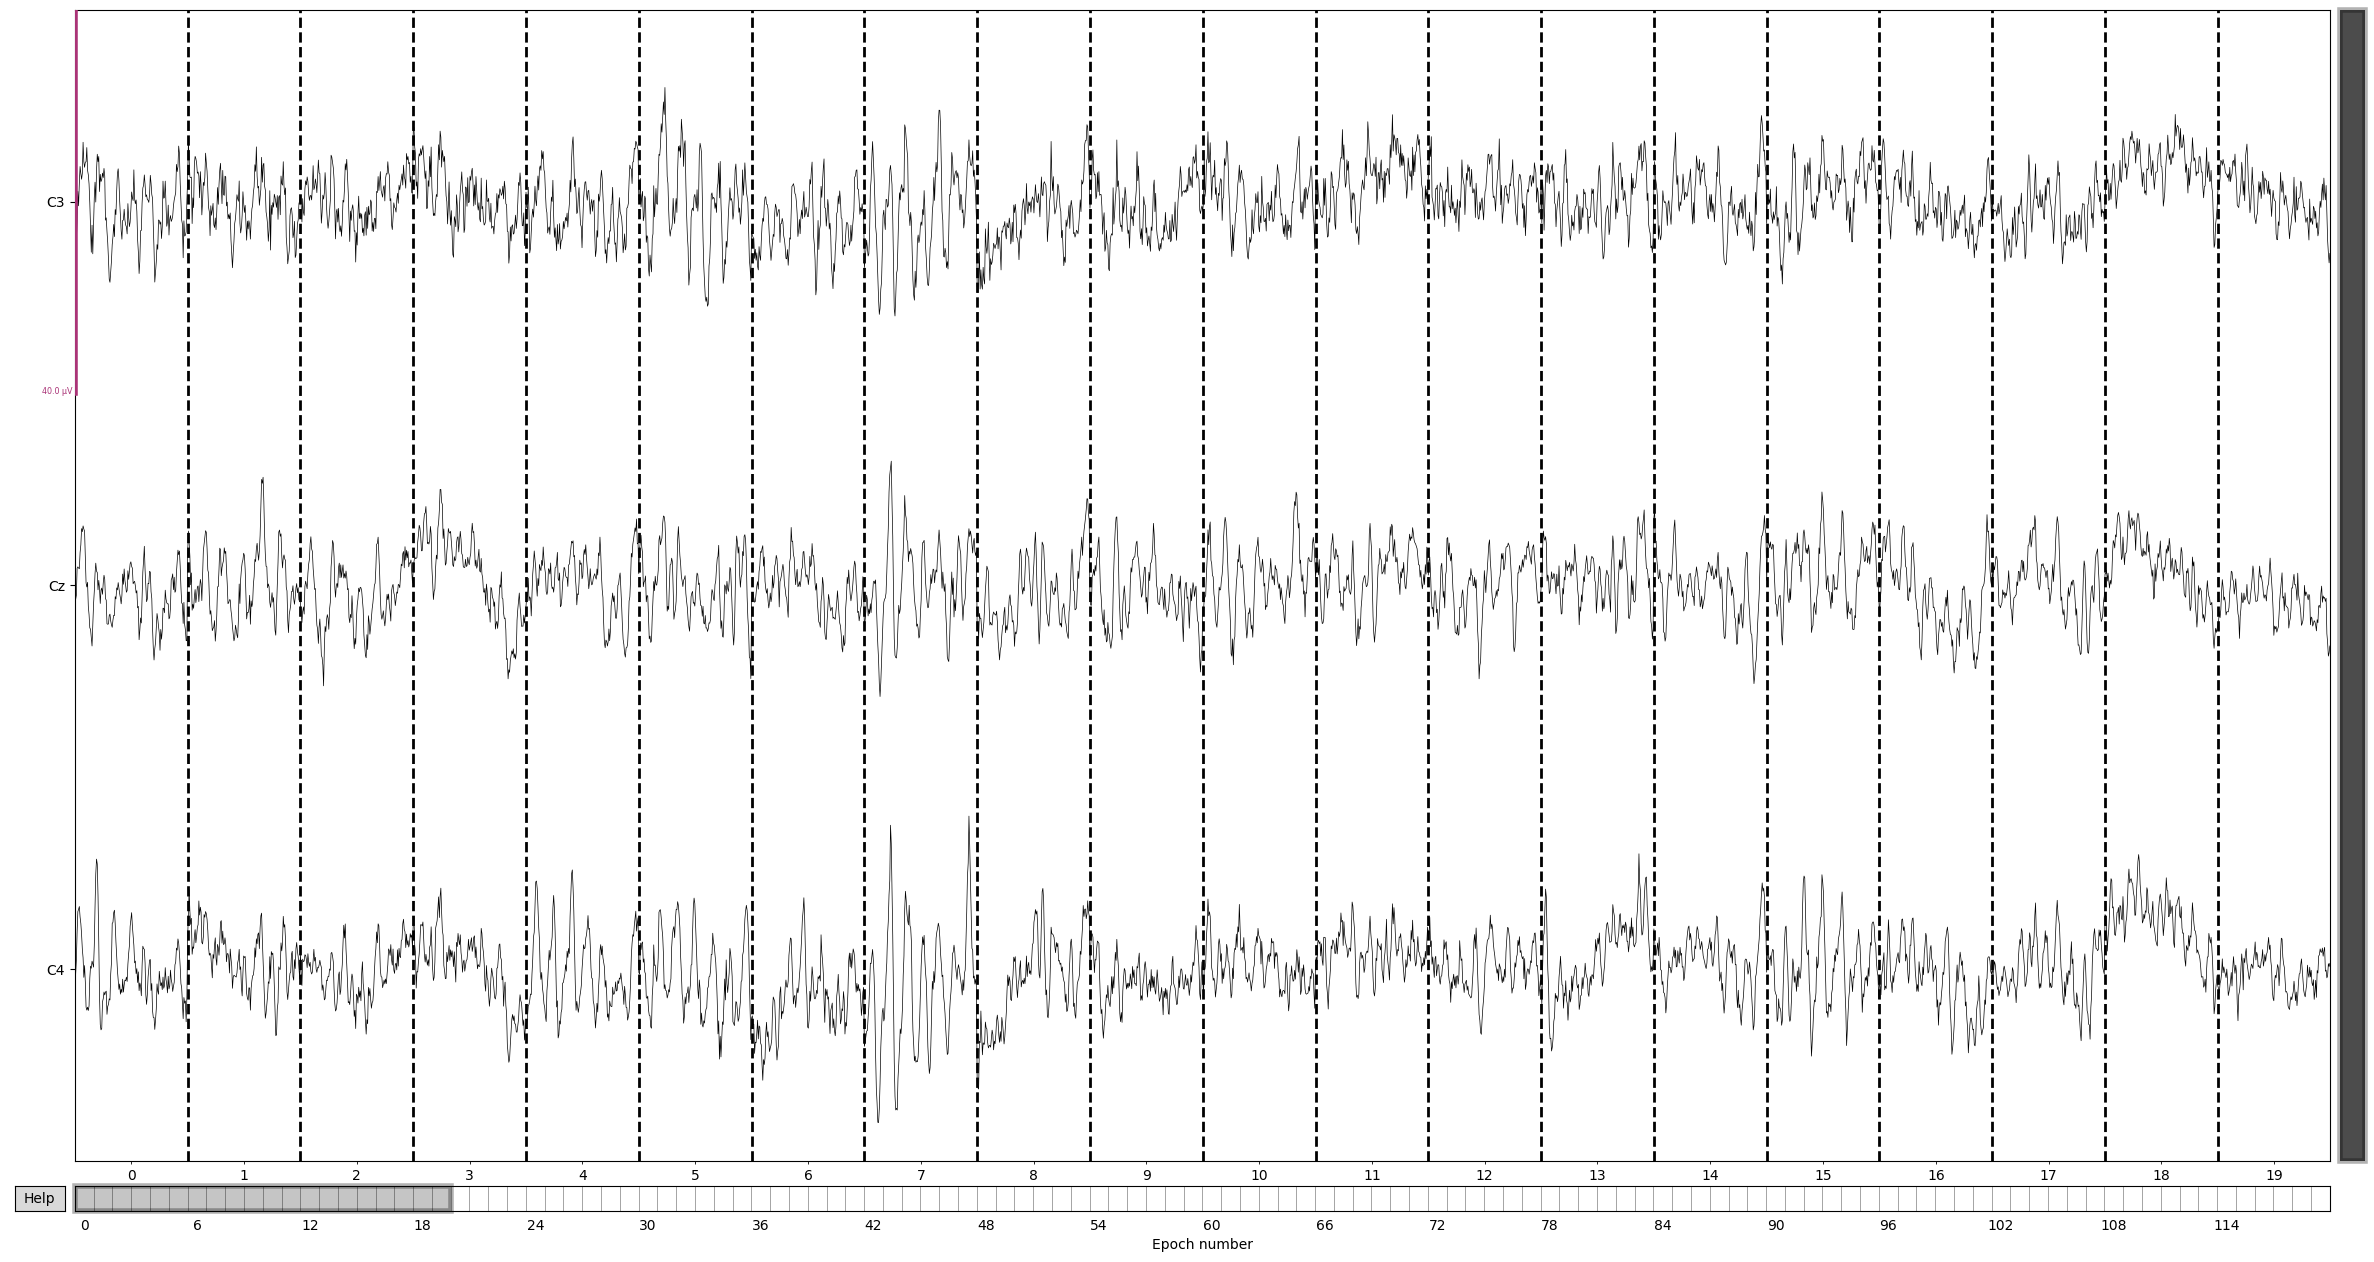

    Using multitaper spectrum estimation with 7 DPSS windows


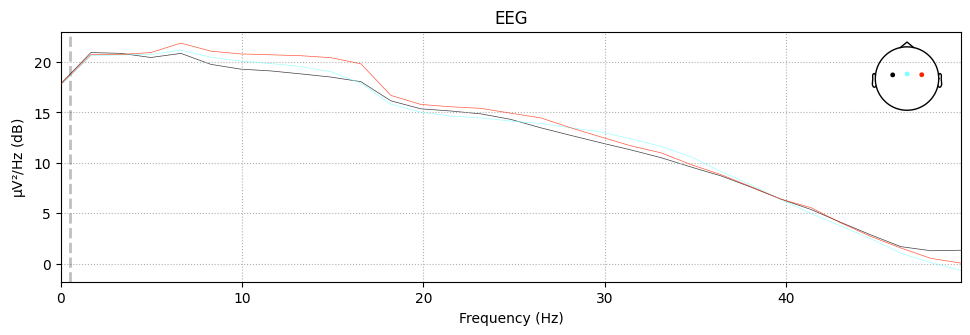

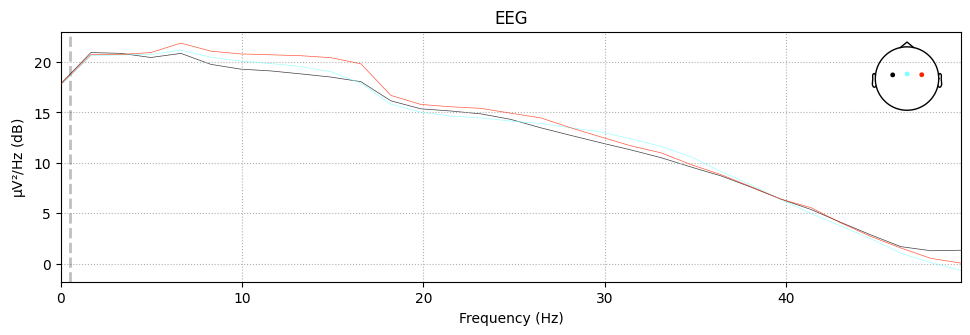

In [22]:
print(epochs1)
epochs1.plot()
epochs1.plot_psd(fmax=50)

In [18]:
def amplitude(x):
    """Data augmentation for adding noise to amplitude of sepctral image
    1 electrode คือ การดึงค่าคลื่นจาก electrode นั้นมา ซึ้่ง electrode นั้นคือ fc fz c4 c3 ประมาณนี้
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        reconstructed new time series from inverse STFT
    """
    print("Hello")



In [25]:
import torch   
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import Subset  
from torch import nn  
import torch.nn.functional as F  
from torch.utils.data import RandomSampler  
from torch.utils.data import SequentialSampler  

from common import EpochsDataset  

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)
train_idx, test_idx = next(cv_split)


def scale(X):
    """Standard scaling of data along the last dimention.
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    return X / 2e-5

dataset = EpochsDataset(epochs_data, labels, transform=scale)

ds_train, ds_valid = Subset(dataset, train_idx), Subset(dataset, test_idx)

batch_size_train = len(ds_train)
batch_size_valid = len(ds_valid)
sampler_train = RandomSampler(ds_train)
sampler_valid = SequentialSampler(ds_valid)

# create loaders
num_workers = 0
loader_train = \
    DataLoader(ds_train, batch_size=batch_size_train,
               num_workers=num_workers, sampler=sampler_train)
loader_valid = \
    DataLoader(ds_valid, batch_size=batch_size_valid,
               num_workers=num_workers, sampler=sampler_valid)

In [26]:
class SingleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # define model architecture
        # torch.Size([36, 1, 64, 256])
        # temporal convolutional kernel 25 filter with size(11,1)
        #input [224, 1, 22, 256]
        #A block
        self.temporalConv = nn.Conv1d(in_channels=1,out_channels=8,kernel_size=(11,1),stride=1)
        self.spatialConv = nn.Conv1d(in_channels=8,out_channels=8,kernel_size=(12,1),stride=1)
        self.maxPooling = nn.MaxPool2d((1,3))
        
        #B block
        # 1st convo output [25,1,371]
        #input [224, 8, 1, 85]
        self.firstConv = nn.Conv1d(in_channels=8, out_channels=8,kernel_size=(1,1))
        self.secondConv = nn.Conv1d(in_channels=8, out_channels=33,kernel_size=(1,1))
        self.thirdConv = nn.Conv1d(in_channels=33,out_channels=33,kernel_size=(1,1))
        self.maxPooling2 = nn.MaxPool2d((1,3))
        
        #C block
        #input [224, 41, 1, 28]
        self.classify = nn.Conv1d(in_channels=41,out_channels=41,kernel_size=(1,11))
        self.maxPooling3 = nn.MaxPool2d((1,3))
        self.flatten = nn.Flatten()
        self.elu = nn.ELU()
        self.fully = nn.Linear(246,2)
        
        
    def forward(self, x):
        #Conv1d(1,ch,kernel_size=10) on tensor [batch=1, channels=1, time=400]
        x = self.temporalConv(x)
        x= self.spatialConv(x)
        x = self.elu(x)
        x = self.maxPooling(x)
        
        out2 = self.firstConv(x)
        out2 = self.secondConv(out2)
        out2 = self.thirdConv(out2)
        out3 = torch.cat((x,out2),1)
        out3 = self.maxPooling2(out3)
        
        out3 = self.classify(out3)
        out3 = self.maxPooling3(out3)
        out3 = self.flatten(out3)
        out3 = self.elu(out3)
        out3 = self.fully(out3)
        out3 = self.elu(out3)
        out3 = F.log_softmax(out3, dim=1)
        
        return out3

In [27]:
#device = 'cuda'
device = 'cpu'
model = SingleNet()


In [28]:
# Train
from common import train

lr = 1e-4
n_epochs = 50
patience = 100

model.to(device=device) 
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)

train(model, loader_train, loader_valid, optimizer, n_epochs, patience, device)


Starting epoch 1 / 50


  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (3 x 151). Kernel size: (11 x 1). Kernel size can't be greater than actual input size

In [9]:
# Test model works:

n_samples_test = 10
y_test = torch.randint(0, 2, (n_samples_test,))
y_pred = model.forward(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]))
output = F.nll_loss(y_pred, y_test)
_, top_class = y_pred.topk(1, dim=1)


In [10]:
print(top_class)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
